### Дополнительное задание №2

<details>
  <summary>Формулировка</summary>

Реализуйте модель для классификации изображений датасета [FashionMNIST](https://pytorch.org/vision/0.20/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST) на PyTorch Lightning
1. **1 балл** Создайте класс `FashionMNISTDataModule`, реализуйте в нем:
    - загрузку данных, 
    - предобработку (перевод в тензоры, нормализация, etc
    - разбиение на train/val/test части
    - создание dataloader'ов- **1 балл**
2. **2 балла** Создайте класс модели `FashionMNIST` (наследник `LightningModule`), реализуйте в нем:
    - training_step, validation_step, test_step
    - расчет метрик на валидации и тестировании из TorchMetrics: F1, ROC AUC
    - логирование метрик и функций потерь на каждой эпохе валидации/теста
    - подберите подходящие, на ваш взгляд, optimizer и lr-scheduler, а также их гиперпараметры
3. **1 балл** Обучите модель с помощью trainer'а:
    - добавьте `EarlyStopping`
    - реализуйте визуализацию логов через tensorboard
    - проверьте качество на тестовой части данных
    

Обеспечена воспроизводимость решения: зафиксированы random_state, ноутбук воспроизводится от начала до конца без ошибок - **1 балл**
    
</details>

### Библиотеки

In [32]:
# библиотеки
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import F1Score, ROC, AUROC
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

import pytorch_lightning as pl
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [33]:
def set_random_state(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_random_state(42)

### Создание класса FashionMNISTDataModule

In [34]:
class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "../data/data_extra_2/", batch_size: int = 64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def prepare_data(self):
        # Скачиваем данные
        datasets.FashionMNIST(self.data_dir, train=True, download=True)
        datasets.FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Разделяем данные на train/val/test
        full_dataset = datasets.FashionMNIST(self.data_dir, train=True, transform=self.transform)
        self.train_dataset, self.val_dataset = random_split(full_dataset, [55000, 5000])
        self.test_dataset = datasets.FashionMNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=10)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=10)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=10)
    
    def show_samples(self, num_samples=10):
        # Получаем обучающий DataLoader
        train_loader = self.train_dataloader()
        # Берем один батч данных
        images, labels = next(iter(train_loader))
        # Классы FashionMNIST
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

        # Создаем сетку для отображения изображений
        plt.figure(figsize=(10, 10))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            # Переводим изображение обратно в диапазон [0, 1] для отображения
            img = images[i].squeeze().numpy()
            img = (img * 0.5) + 0.5  # Отмена нормализации
            plt.imshow(img, cmap='gray')
            plt.title(class_names[labels[i]])
            plt.axis('off')
        plt.show()

### Создание класса FashionMNIST (наследник от верхнего класса)

In [35]:
class FashionMNISTModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Сверточные слои
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Линейные слои
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

        # Метрики
        self.f1 = F1Score(task="multiclass", num_classes=10)
        self.auroc = AUROC(task="multiclass", num_classes=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Пулинг 2x2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # Пулинг 2x2
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.f1.update(y_hat, y)
        self.auroc.update(y_hat, y)
        return loss

    def on_validation_epoch_end(self):
        self.log('val_f1', self.f1.compute(), prog_bar=True, logger=True)
        self.log('val_auroc', self.auroc.compute(), prog_bar=True, logger=True)
        self.f1.reset()
        self.auroc.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.f1.update(y_hat, y)
        self.auroc.update(y_hat, y)
        return loss

    def on_test_epoch_end(self):
        self.log('test_f1', self.f1.compute(), prog_bar=True, logger=True)
        self.log('test_auroc', self.auroc.compute(), prog_bar=True, logger=True)
        self.f1.reset()
        self.auroc.reset()

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
        return [optimizer], [scheduler]

### Как вообще выглядят данные?

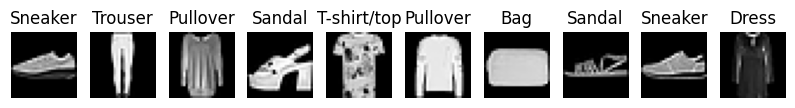

In [36]:
# Инициализация данных и модели
data_module = FashionMNISTDataModule()
model = FashionMNISTModel()

# Подготовка данных (вызов setup() для загрузки данных в память)
data_module.setup()

# Показать 100 случайных изображений
data_module.show_samples(num_samples=10)

### Обучение модели

In [37]:
# Ранняя остановка
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=True,
    mode='min'
)

# Инициализация Trainer
trainer = Trainer(
    max_epochs=10,
    callbacks=[early_stop_callback],
    logger=pl.loggers.TensorBoardLogger('../logs/logs_extra_2'),
    deterministic=True
)

# Обучение модели
trainer.fit(model, data_module)

# Тестирование модели
trainer.test(model, datamodule=data_module)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | conv1 | Conv2d            | 320    | train
1 | conv2 | Conv2d            | 18.5 K | train
2 | fc1   | Linear            | 401 K  | train
3 | fc2   | Linear            | 1.3 K  | train
4 | f1    | MulticlassF1Score | 0      | train
5 | auroc | MulticlassAUROC   | 0      | train
----------------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/anastasia/docs/ITMO/DL_Course/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/anastasia/docs/ITMO/DL_Course/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.343


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.288


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.246


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.229


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.220


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.214


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.213


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.210


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.208


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.207
`Trainer.fit` stopped: `max_epochs=10` reached.
/Users/anastasia/docs/ITMO/DL_Course/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.9951269030570984
         test_f1             0.920199990272522
     test_loss_epoch        0.22897395491600037
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.22897395491600037,
  'test_f1': 0.920199990272522,
  'test_auroc': 0.9951269030570984}]

### Результаты
Выполните команду в терминале, а затем перейдите по ссылке http://localhost:6006/
```
tensorboard --logdir=logs/logs_extra_2/lightning_logs/version_6/
```